In [1]:
# Check device number
!ls -ltrh /dev/video*

crw-rw----+ 1 root video 81, 0 Dec 31  1969 /dev/video0
crw-rw----+ 1 root video 81, 1 Dec 31  1969 /dev/video1


In [2]:
import torch
from ultralytics import YOLO
import os

print(torch.__version__, "cuda:", torch.cuda.is_available())

#make ft32 tensorrt file
model = YOLO("yolo.pt", task="pose")    # 또는 task="detect"
model.export(format="engine")

os.rename("yolo.engine", "yolo_fp32.engine")
os.rename("yolo.onnx", "yolo_fp32.onnx")


2.3.0 cuda: True
WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics 8.3.187 🚀 Python-3.10.12 torch-2.3.0 CUDA:0 (Orin, 7620MiB)
YOLO11n-pose summary (fused): 109 layers, 2,956,000 parameters, 0 gradients, 7.8 GFLOPs

PyTorch: starting from 'yolo.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 68, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...


ERROR: Could not find a version that satisfies the requirement onnxruntime-gpu (from versions: none)
ERROR: No matching distribution found for onnxruntime-gpu


WARNING ⚠️ Retry 1/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.59" "onnxruntime-gpu" ' returned non-zero exit status 1.


ERROR: Could not find a version that satisfies the requirement onnxruntime-gpu (from versions: none)
ERROR: No matching distribution found for onnxruntime-gpu


WARNING ⚠️ Retry 2/2 failed: Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.59" "onnxruntime-gpu" ' returned non-zero exit status 1.
WARNING ⚠️ requirements: ❌ Command 'pip install --no-cache-dir "onnx>=1.12.0,<1.18.0" "onnxslim>=0.1.59" "onnxruntime-gpu" ' returned non-zero exit status 1.

ONNX: starting export with onnx 1.19.0 opset 17...
WARNING ⚠️ ONNX: simplifier failure: No module named 'onnxslim'
ONNX: export success ✅ 16.7s, saved as 'yolo.onnx' (11.6 MB)

TensorRT: starting export with TensorRT 10.3.0...
[09/04/2025-19:30:00] [TRT] [I] [MemUsageChange] Init CUDA: CPU +2, GPU +0, now: CPU 697, GPU 5798 (MiB)
[09/04/2025-19:30:04] [TRT] [I] [MemUsageChange] Init builder kernel library: CPU +927, GPU +900, now: CPU 1667, GPU 6724 (MiB)
[09/04/2025-19:30:05] [TRT] [I] ----------------------------------------------------------------
[09/04/2025-19:30:05] [TRT] [I] Input filename:   yolo.onnx
[09/04/2025-19:30:05] [TRT] [I] ONNX IR version:  0.0.8
[09/04/2

In [2]:
from flask import Flask, Response
from ultralytics import YOLO
import cv2

# YOLO 모델 불러오기 (best.pt or .engine 가능)
model = YOLO("yolo_fp32.engine", task="pose")


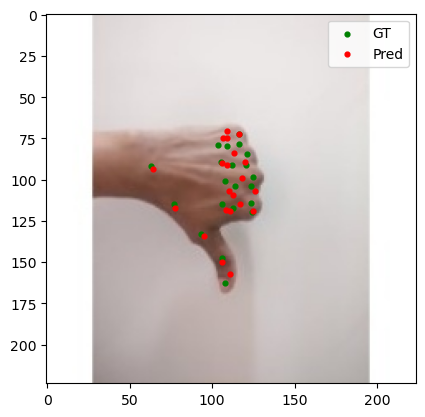

PCK@1.00px: 0.1487
PCK@3.00px: 0.5932
PCK@5.00px: 0.7729
PCK@7.00px: 0.8438


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PCK@10.00px: 0.8892


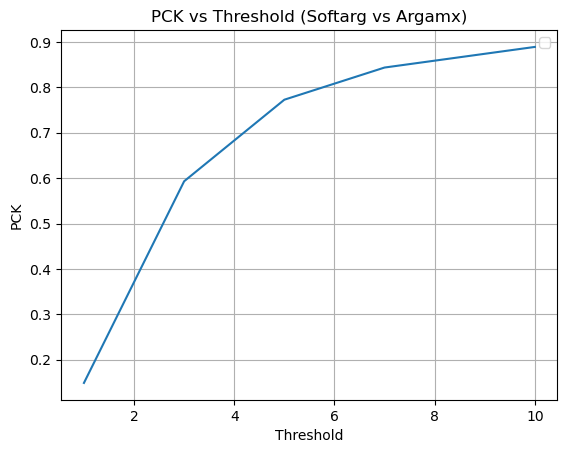

In [16]:
import time, glob, random
import numpy as np
import matplotlib.pyplot as plt

# Paths
img_val_dir   = f"../data/images/val"
label_val_dir = f"../data/labels/val"

images_test = sorted(glob.glob(f"{img_val_dir}/*.jpg", recursive = True))
labels_test = sorted(glob.glob(f"{label_val_dir}/*.txt", recursive = True))

#Test set generation
valid_numbers = random.sample(range(int(len(images_test))), int(len(images_test) / 2))
test_numbers = [i for i in range(len(images_test)) if i not in valid_numbers]

images_test = sorted([images_test[i] for i in test_numbers])
labels_test = sorted([labels_test[i] for i in test_numbers])

# 이미지 읽기
x = 100

img = cv2.imread(images_test[x]) 

label = labels_test[x]

def get_gt(label_path, W, H):
    with open(label_path, "r", encoding="utf-8") as f:
        vals = list(map(float, f.read().split()))
    kpts = np.array(vals[5:], dtype=np.float32).reshape(-1, 3)  # (K, x_norm, y_norm, v)
    kpts_xy = kpts[:, :2] * np.array([W, H], np.float32)        # 정규화 → 픽셀
    return kpts_xy.astype(np.float32)

def predict_kpts_xy_one(img_bgr, model):
    """
    YOLO pose 결과에서 최고 confidence 인스턴스 1개만 (K,2) 픽셀좌표로 반환.
    검출 없으면 None 반환.
    """
    res = model.predict(img_bgr, verbose=False)[0]

    # keypoints 객체 자체가 없거나, 검출 수 N==0인 경우
    if (res.keypoints is None) or (getattr(res.keypoints, "xy", None) is None):
        return None
    xy = res.keypoints.xy  # shape: (N, K, 2)
    if xy is None or xy.shape[0] == 0:
        return None

    # 여러 인스턴스면 최고 conf 선택(가능한 경우)
    idx = 0
    if (res.boxes is not None) and hasattr(res.boxes, "conf") and (len(res.boxes) > 0):
        idx = int(res.boxes.conf.argmax().item())

    return xy[idx].cpu().numpy().astype(np.float32)  # (K,2)


# 단일 샘플 시각화도 이렇게 수정
x = min(100, len(images_test) - 1)
img = cv2.imread(images_test[x])
H, W = img.shape[:2]
label = labels_test[x]

pred_xy = predict_kpts_xy_one(img, model)  # (K,2) or None
gts_xy  = get_gt(label, W, H)              # (K,2)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(gts_xy[:, 0], gts_xy[:, 1], c="g", s=12, label="GT")
if pred_xy is not None:
    plt.scatter(pred_xy[:, 0], pred_xy[:, 1], c="r", s=12, label="Pred")
plt.legend(); plt.show()

def calculate_pck(threshold_px):
    total_correct = 0
    total_pts = 0
    skipped = 0

    for img_path, label_path in zip(images_test, labels_test):
        img = cv2.imread(img_path)
        H, W = img.shape[:2]

        pred = predict_kpts_xy_one(img, model)  # (K,2) or None
        gt   = get_gt(label_path, W, H)         # (K,2)

        if pred is None:
            skipped += 1
            continue

        K = min(len(gt), len(pred))
        dists = np.linalg.norm(pred[:K] - gt[:K], axis=1)  # (K,)
        total_correct += int((dists <= threshold_px).sum())
        total_pts     += K

    pck = (total_correct / total_pts) if total_pts > 0 else 0.0
    print(f"PCK@{threshold_px:.2f}px: {pck:.4f}")
    return pck


thresholds = [1, 3, 5, 7, 10]
pck_results = [calculate_pck(t) for t in thresholds]

# pck visualization
plt.plot(thresholds, pck_results)
plt.xlabel("Threshold")
plt.ylabel("PCK")
plt.title("PCK vs Threshold (Softarg vs Argamx)")
plt.legend()
plt.grid(True)
plt.show()
    

In [ ]:
for _ in range(10):
    _ = model.predict(img)

print("\nLatency Benchmarking...")
times = []
for img in images_test[:100]:  # 테스트셋 일부만 (예: 100장)
    input = cv2.imread(img)
    t0 = time.perf_counter()
    _ = model.predict(input)
    t1 = time.perf_counter()
    times.append((t1 - t0) * 1000)  # ms

print(f"평균 Latency: {np.mean(times):.2f} ms")
print(f"FPS (추론 기준): {1000/np.mean(times):.2f}")

In [5]:
c_index = 1 #Camera index can be changed

cap = cv2.VideoCapture(c_index) 
assert cap.isOpened(), "Camera open failed."

app = Flask(__name__)

def gen_frames():
    while True:
        ret, frame = cap.read() 
        if not ret:
            break

        # YOLO inference
        results = model.predict(source=frame, imgsz=640, verbose=False)
        annotated = results[0].plot()  # draw inference results

        # JPEG encoding
        ret, buffer = cv2.imencode('.jpg', annotated)
        if not ret:
            continue #If encoding is failed, skip

        # MJPEG streaming: MJPEG = Motion JPEG
        yield (b'--frame\r\n'
               b'Content-Type: image/jpeg\r\n\r\n' + buffer.tobytes() + b'\r\n')

@app.route('/')
def video_feed():
    return Response(gen_frames(), mimetype='multipart/x-mixed-replace; boundary=frame')

if __name__ == "__main__":
    try:
        app.run(host="0.0.0.0", port=8000, debug=False, use_reloader=False)
    finally:
        cap.release()
        cv2.destroyAllWindows()


[ WARN:0@324.566] global cap_v4l.cpp:914 open VIDEOIO(V4L2:/dev/video1): can't open camera by index
[ERROR:0@324.764] global obsensor_uvc_stream_channel.cpp:163 getStreamChannelGroup Camera index out of range


AssertionError: Camera open failed.